# Objective #1

In [107]:
from itertools import product
import json

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error, mean_absolute_percentage_error

## 1.1. Dataset preparation
### 1.1.1. Split into training and IVS
- `train_df` -- training set for model training/selection
- `ivs_df` -- independet validation set (IVS) for the final benchmark

In [108]:
df = pd.read_csv("parkinsons_updrs.data")

n, m = df.shape

train_size = int(0.8 * n)
train_df = df.iloc[:train_size]
ivs_df = df.iloc[train_size:]

In [109]:
train_x = np.array(train_df.drop(["subject#", "age", "sex", "test_time", "motor_UPDRS", "total_UPDRS"], axis=1))
train_y = np.array(train_df["motor_UPDRS"])
ivs_x = np.array(ivs_df.drop(["subject#", "age", "sex", "test_time", "motor_UPDRS", "total_UPDRS"], axis=1))
ivs_y = np.array(ivs_df["motor_UPDRS"])

## 1.2. Model Selection

In [110]:
def simple_cross_validation(*, model, x, y, train_partition=(0, 0.8), metrics={"mae": mean_absolute_error}):
    n, m = x.shape
    
    start = int(train_partition[0] * n)
    end = int(train_partition[1] * n)
    
    x_train = x[start:end, :]
    y_train = y[start:end]
    x_test = np.concatenate((x[:start, :], x[end:, :]))
    y_test = np.concatenate((y[:start], y[end:]))
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    return {metric_name: metric_f(y_test, y_pred) for (metric_name, metric_f) in metrics.items()}


def kfold(*, model, x, y, k=5, metrics={"mae": mean_absolute_error}):
    n, m = x.shape
    results = []
    
    for i in range(k):
        start = i * (1/k)
        end = start + (1/k)
        if (i + 1) == k:
            end = 1.0
            
        result = simple_cross_validation(model=model, x=x, y=y, train_partition=(start, end), metrics=metrics)
        
        results.append(result)
    
    return results


def model_selection(x: np.ndarray, y: np.ndarray):
    
    # Split into train and test
    n, m = x.shape
    partition = int(0.8 * n)
    x_train = x[:partition, :]
    x_test = x[partition:, :]
    y_train = y[:partition]
    y_test = y[partition:]
    
    # Hyperparameters
    criterions = ["squared_error"]
    splitters = ["best"]
    max_depths = [3, 4, 12, None]
    hyper_parameters = product(criterions, splitters, max_depths)
    
    results = {}
    
    for p in hyper_parameters:
        criterion, splitter, max_depth = p
        
        model = tree.DecisionTreeRegressor(criterion=criterion,
                                           splitter=splitter,
                                           max_depth=max_depth)
        
        
        # Use either simple_cross_validation or kfold below
        #result = simple_cross_validation(model=model, x=x, y=y, metrics={"mae": mean_absolute_error, "rve": explained_variance_score})
        result = kfold(model=model, x=x, y=y, k=5, metrics={"mae": mean_absolute_error, "rve": explained_variance_score})
        
        results[p] = {"model": model, "evaluation": result}
        
    # TODO: select the best model and return it
    return results

results = model_selection(train_x, train_y)
print(json.dumps({"-".join([str(p) for p in k]): v["evaluation"] for (k, v) in results.items()}, indent=4))

{
    "squared_error-best-3": [
        {
            "mae": 9.14460945135377,
            "rve": -0.9812084426630414
        },
        {
            "mae": 7.731570121805598,
            "rve": -0.004883559452879771
        },
        {
            "mae": 8.57498559421701,
            "rve": -0.24235183734294385
        },
        {
            "mae": 8.588457783088712,
            "rve": -0.8192318073717832
        },
        {
            "mae": 8.61314601433357,
            "rve": -0.39789037155257434
        }
    ],
    "squared_error-best-4": [
        {
            "mae": 8.941997178205796,
            "rve": -0.9468426733270665
        },
        {
            "mae": 7.804415849089664,
            "rve": -0.02261655359532755
        },
        {
            "mae": 9.208440697969555,
            "rve": -0.33308881246691047
        },
        {
            "mae": 8.119310853348297,
            "rve": -0.7009597997679424
        },
        {
            "mae": 8.54697003155055,


## 1.3. Validate against IVS

{'mae': 7.475312481127658, 'rve': -0.4144267646280848}


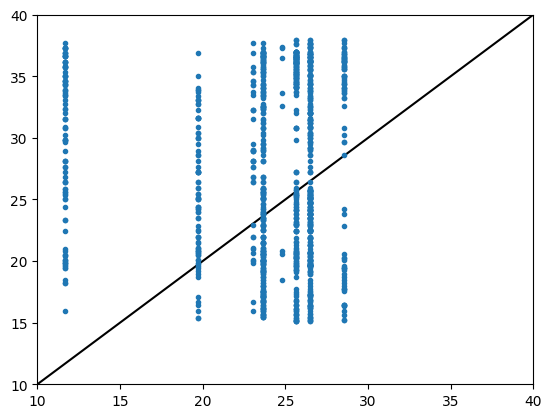

In [111]:
# Example of selected model. This should be trained on the complete train data set
selected_model = results[("squared_error","best",3)]["model"]

def validate_agains_ivs(*, model, ivs_x, ivs_y, metrics={"mae": mean_absolute_error, "rve": explained_variance_score}):
    y_pred = model.predict(ivs_x)
    
    plt.xlim(10, 40)
    plt.ylim(10, 40)
    plt.axline((0, 0), slope=1, color="black")
    plt.plot(y_pred, ivs_y, ".")
    
    return {metric_name: metric_f(ivs_y, y_pred) for (metric_name, metric_f) in metrics.items()}

    
performance_on_ivs = validate_agains_ivs(model=selected_model, ivs_x=ivs_x, ivs_y=ivs_y)
print(performance_on_ivs)
